# Import relevent packages

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
import time

Using TensorFlow backend.


In [2]:
% matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Convolution Operation


A discrete convolution operation involves dragging a *mask*, also known as a *kernel* over some data (i.e. image). The mask is typically small, for instance a 3x3 matrix, while the data is large: think image size. By putting the convolution mask over a single pixel in the image, one can compute the result by simple elementiwise multiplication and addition. For 1D this takes the following form

In [4]:
from numpy import convolve

# 1D convolution
a = [1,2,2,2,2,3,4,1,2,3,4,1,2,2,2,3,2] # data vector
b = [1,1,1] # convolution kernel

print(convolve(a,b)) # element i is the sum of i-1,i and i+1

[1 3 5 6 6 7 9 8 7 6 9 8 7 5 6 7 7 5 2]


In [5]:
b = [-1,0,1]
print(convolve(a,b)) # element i is the difference between element i+1 and i-1

[-1 -2 -1  0  0 -1 -2  2  2 -2 -2  2  2 -1  0 -1  0  3  2]


One can see that this particular kernel gives an approximation to the derivative. In fact it is equal to [central difference](http://mathworld.wolfram.com/CentralDifference.html) for a step size of 1/2.

Note that it is not obvious what to do at the boundary of the domain since at index i=0, we don't have avilable any value for i-1. Popular choices are to treat these values as 0, use the nearest boundary or use from the other boundary (periodic). Other choices are to simply don't compute for these values of i which means that the output vector will be smaller than the input vector.

### 2D convolution

![Convolution operation](./images/convolution.jpg)

2D convoltuion creates a 2D kernel to drag across the data.

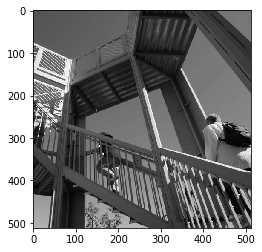

In [6]:
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.misc import ascent
import numpy as np

img = ascent()
plt.imshow(img, cmap='gray')
plt.show()

[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


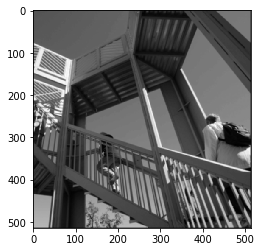

In [7]:
average = np.ones((3,3)) # create an "averaging mask" of size 3x3
print(average)
blurred_image = convolve2d(img, average)
plt.imshow(blurred_image, cmap='gray')
plt.show()

[[-1, 0, 1]]


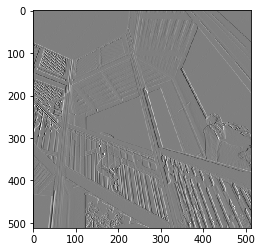

In [8]:
dI_dx = [[-1, 0, 1]] # create a [3,1] mask that approximates the x-derivative
print(dI_dx)
dx_img = convolve2d(img, dI_dx)
plt.imshow(dx_img, cmap='gray')
plt.show()

This particular map is usefull for detecting sharp intensity changes in the x-direction of the image: that is vertical edges. Other convolution operations include finding the y-derivative which is great for detecting horiztonal edges

[[-1], [0], [1]]


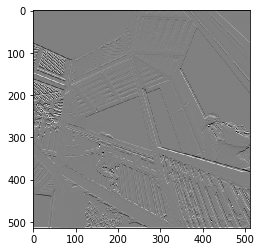

In [9]:
dI_dy = [[-1], [0], [1]] # create a [1,3] mask that approximates the y-derivative
print(dI_dy)
dy_img = convolve2d(img, dI_dy)
plt.imshow(dy_img, cmap='gray')
plt.show()

Convolution operations are used extensively in image processing. They prove indispensible for feature detection (edges, shapes etc) and enhancement (noise removal, edge sharpening). Traditional computer vision almost always started with mulitple convolution operations followed by extracting shapes and forms or other postprocessing.

Traditionally: a handful (3-10) of these filters have been crafted by a human engineer for the task at hand. We will now use Convolutional Neural Network to allow for a machine learning algorithm to design these filters for us and we will only need to specify how many we want.

# Maxpooling

Max pooling is mostly used to contain the data size. During a convolution layer, we generate multiple convolution kernels which each generate a full resolution image. If your original image was (128,128) pixels and we apply 40 filters to this, then we now have 40 (128,128) images as input after our first layer, multiplying the datasize by manyfold. Max pooling allow us to constrain this size while still keeping relevant features. A simple 2x2 max pooling filter will keep the maximum value of each (2x2) block of the dataset, effectively quartering the data size.

![Max pooling](./images/maxpool.png)

The trick is to balance convolution layer which tend to grow the data size and maxpooling layers which shrink their size so that we are able to maintain the features we want while still maintaining reasonable computational speed and don't suffer from low variance or large bias.

## A typical CNN structure

![Full structure of a CNN](./images/cnn.jpg)

The typical structure of a convolutional neural network. During convolution layers, we add multiple convolution filters and grow the data set. During max pooling layers we shrink the size by only keeping the maximum from a small region. The final stage of a CNN is a regular ANN. We move away from image-representation of the data and store it all in a simple vector by "flattening" the data. After this, we create one or more fully connected layers and also train these weights.

The weights that are to be trained are the convolution filters. We specify manually the number and size of such filters that we want, but leave their weights to be optimized at the learning stage. Max pooling layers are deterministic and have no weights to be optimized.

### A simple example

If we consider the input image from above along with the three convolution kernels

$$ w^{(1)}=\frac{1}{9}\left[\begin{array}{ccc}1&1&1\\1&1&1\\1&1&1\end{array}\right],\quad
   w^{(2)}=           \left[\begin{array}{ccc}0&0&0\\-1&0&1\\0&0&0\end{array}\right],\quad
   w^{(3)}=           \left[\begin{array}{ccc}0&1&0\\0&0&0\\0&-1&0\end{array}\right] $$
   
then these may form a single convolution layer. It takes as input a 2-dimensional input image of size, say 128x128 and outputs three images of size 128x128. We may intepret this as three seperate images or simply as a (128,128,3) data volume.

### Why convolution?

With ANN we flatten the image data into a single vector. An $n\times m$ image consist of $nm$ features. This means that our data dimension is $nm$. However, from intuition, we expect that a (grayscale) image is an inherently 2-dimensional object. The spatial connectivity has been lost during image flattening and the trained network is sensitive to translating the image just a single pixel in one direction since this will use completely different neurons.

Convolution allow us to reclaim this spatial dependence and treat the image as it is, a truly 2-dimensional dataset. This allows the computational complexity to increase slower with increasing image size as well as preserve translation invariance more easily.

# Activation

As per usual, we will use an activation function to break linearity. In practice, the rectified linear unit (relu) has given remarkably good results. 

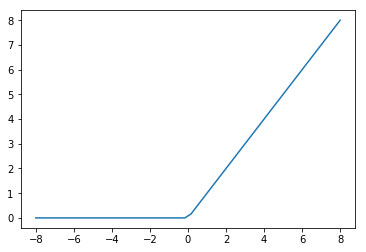

In [10]:
def relu(z):
    return np.maximum(z,0)

z = np.linspace(-8,8)
plt.plot(z, relu(z))
plt.show()

# A keras implementation of a CNN

Building Convolutional Neural Network in keras is actually easier than building the artificial neural network. We use MNIST database of hand-written digits

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer

# create preprocessor
categorical_transform = LabelBinarizer().fit(np.arange(10))

# Read the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Transform the data to usable form (Convolution layers expect 4d tensor as input [n_images, width, height, colors])
X  = X_train.reshape(60000,28,28,1) / 255
Xt = X_test.reshape( 10000,28,28,1) / 255
y  = categorical_transform.transform(y_train)
yt = categorical_transform.transform(y_test)


# Initialising the CNN
model = Sequential()

# Step 1 - Convolution (32 filters / feature detectors each having 3x3 dimension)
model.add(Conv2D(16, (3, 3), input_shape = (28, 28,1), activation = 'relu'))

# Step 2 - Pooling (3x3 filter)
model.add(MaxPooling2D(pool_size = (3,3), strides=2))

# Adding a second convolutional layer (32 filters / feature detectors each having 3x3 dimension)
model.add(Conv2D(8, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides=2))

# Step 3 - Flattening (Flatten the previous layers into a one dimensional array to be fed to a ANN)
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


We will now train the network. The below code may take long (several minutes) to run, depending on your hardware.

In [12]:
# Training the CNN
model.fit(X,y,
         epochs=10,
         batch_size=100,
         validation_data=(Xt,yt))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.4188 - acc: 0.8750 - val_loss: 0.1319 - val_acc: 0.9585
Epoch 2/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.1212 - acc: 0.9623 - val_loss: 0.0980 - val_acc: 0.9696
Epoch 3/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0944 - acc: 0.9711 - val_loss: 0.0757 - val_acc: 0.9744
Epoch 4/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0798 - acc: 0.9753 - val_loss: 0.0694 - val_acc: 0.9773
Epoch 5/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0711 - acc: 0.9784 - val_loss: 0.0629 - val_acc: 0.9796
Epoch 6/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0627 - acc: 0.9808 - val_loss: 0.0503 - val_acc: 0.9842
Epoch 7/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0571 - acc: 0.9826 - val_loss: 0.0560 - val_acc

For inspiration purposes it might be worthwile to check the [MNIST dataset hall of fame](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) and compare the accuracy that you are getting.

As always in machine learning: there are two main ways to improve your predictions: more advanced models, or more training data. To create a more advanced model one simply adds more layers, or increase the size of the layers you have. This is not always going to give you better predictions as with too many weights to tune, your model becomes prone to overfitting. In this case you will need more data, and there is a clever trick that one can use with image input known as *data augmentation*

## Data augmentation

We can slightly modify our image database to create new images without having to manually tag these by hand. The idea is that if you take an image which have been identified by a human as a 0, then moving this image one pixel to the right (filling the now open left edge by cloning the old left edge), then this will be a new unseen image as far as our model is concerned and training on this image will increase model accuracy, while we can re-use the tag that we already have for 0 human work. There exist a number of such simple transformations that we can apply to images to increase our database.

Keras have built-in support for this data augmentation. Examples of transofmations are
* rescaling image (brightness intensity)
* flipping (vertically or horizontally)
* shift x pixels (width or height direction)
* zoom
* shear

The size of these transformations are always multiplied by a random amount. If one for instance specifies
`width_shift_range=.2`, then this will move the image a random amount up to a maximum of 20% of the total image width. Combining this random effect with permutations of multiple effects creates and almost endless supply of new images to train from. One should note however that these images can be considered of lower quality since they contain *some* new information, but not as much as a new hand-drawn digit created, and classified, by a human contributer.

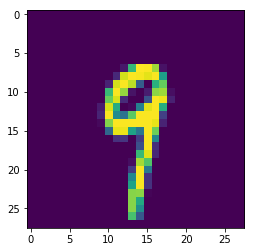

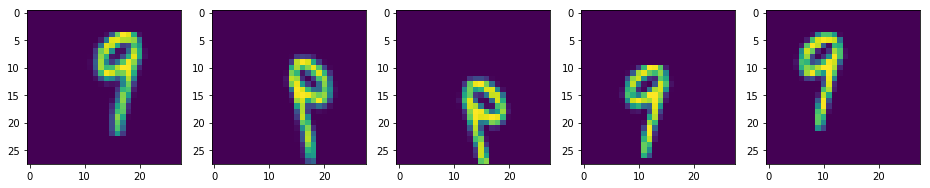

In [13]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# create a generator to create more training images for us
generator = ImageDataGenerator(horizontal_flip=True,
                               width_shift_range=.2,
                               height_shift_range=.2,
                               zoom_range=[1,1.2])

# start with a single image
one_image = X_train[600,:,:]
plt.imshow(one_image)
plt.show()


# generate new images based on this image
k = 0
f,ax = plt.subplots(1,5, figsize=(16,4))
for x0,y0 in generator.flow(X_train[600,:,:].reshape(1,28,28,1),y_train[600].reshape(1,1)):
    ax[k].imshow(x0[0,:,:,0])
    
    # the 'flow' method will create an endless loop, so we have to manually break this at some point
    k += 1
    if k>4:
        break
plt.show()

Of course, `horizontal_flip` makes no sense for digit recognition and will in fact hurt our training method more than it helps, but the example shows what kind of images you get. The slightly odd slicing one has to perform comes from the fact that we in the above example insisted on having just a single image as a sample base. A large-scale implementation of this technique looks like this

In [14]:
for x0,y0 in generator.flow(X,y, batch_size=512):
    print(x0.shape) # this creates 512 new images which are random permutations of randomly chosen images
    print(y0.shape) # the labels are copied from the source image (remember that these are one-hot encoded)
    break;          # flow() will continually produce new images until a break statement is issued

(512, 28, 28, 1)
(512, 10)


We will now use data augmentation to get better predicitions on webcam images

In [16]:
# create a generator to create more training images for us
generator = ImageDataGenerator(width_shift_range=.2,
                               height_shift_range=.2,
                               zoom_range=[1,1.2])

# create a generator which don't change the test images
test_generator = ImageDataGenerator()

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape = (28, 28,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides=2))
model.add(Conv2D(8, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides=2))
model.add(Flatten())

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

validation_data_temp=test_generator.flow(Xt, yt)
model.fit_generator(generator.flow(X,y, batch_size=100),
                    steps_per_epoch=600,
                    epochs=15,
                    validation_data=validation_data_temp, validation_steps=len(validation_data_temp))

Epoch 1/15
600/600 [==============================] - 10s 17ms/step - loss: 0.9838 - acc: 0.6796 - val_loss: 0.3071 - val_acc: 0.9044
Epoch 2/15
600/600 [==============================] - 10s 16ms/step - loss: 0.4394 - acc: 0.8647 - val_loss: 0.2195 - val_acc: 0.9330
Epoch 3/15
600/600 [==============================] - 10s 16ms/step - loss: 0.3403 - acc: 0.8944 - val_loss: 0.2162 - val_acc: 0.9309
Epoch 4/15
600/600 [==============================] - 10s 16ms/step - loss: 0.2758 - acc: 0.9131 - val_loss: 0.1666 - val_acc: 0.9465
Epoch 5/15
600/600 [==============================] - 10s 16ms/step - loss: 0.2428 - acc: 0.9228 - val_loss: 0.1350 - val_acc: 0.9568
Epoch 6/15
600/600 [==============================] - 10s 16ms/step - loss: 0.2183 - acc: 0.9314 - val_loss: 0.1392 - val_acc: 0.9563
Epoch 7/15
600/600 [==============================] - 10s 16ms/step - loss: 0.1995 - acc: 0.9370 - val_loss: 0.1484 - val_acc: 0.9534
Epoch 8/15
600/600 [==============================] - 10s 16ms

# Cats vs Dogs

Apply different kinds of transformations to generate variations if input images for training the network. The image dataset can be downloaded from here: [Cats_dogs.zip](https://www.dropbox.com/s/5dx3zcoxgytihlj/cats_dogs.zip?dl=0) (238 MB). Unzip these files locally. Note the particular file structure which keras takes advantage of: `training_set` consist of one folder for every class in our set of output classes and likewise for `test_set`. Using this structure, then keras can do image extraction, resizing and one-hot encoding for us, making aquiring datasets much easier.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 8000 images belonging to 2 classes.


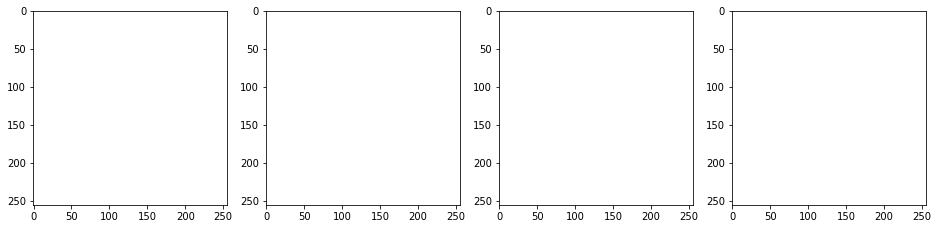

In [17]:
# Much like image augmentation, we can create a 'flow' of images from a directory for us to use.
# This can be used in combination with modifications, or without
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()

f,ax = plt.subplots(1,4, figsize=(16,4))
for (x,y) in generator.flow_from_directory(directory='../../../datasets/cats_dogs/training_set', batch_size=4):
    x = 256-x                     # for some reason, the images here are inverted, so we turn them back
    ax[0].imshow(x[0,:,:,:])
    ax[1].imshow(x[1,:,:,:])
    ax[2].imshow(x[2,:,:,:])
    ax[3].imshow(x[3,:,:,:])
    break
plt.show()

We can add data augmentations to the image generations to create an endless flow of new images to train on. 

Let us now build a CNN that can distinguish between cats and dogs

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten


# we first set up our data stream. This is kindly provided to us by keras if we put our images in 
# the right file structure
train_datagen = ImageDataGenerator(rescale = 1./256,    # feature normalization: all images should be in range [0,1]
                                   shear_range = 0.2,   # shear images by random amount 0-20%
                                   zoom_range = .2,     # zoom images by random amount +/- 20%
                                   horizontal_flip = True) # sometimes perform horizontal flip on images
test_datagen  = ImageDataGenerator(rescale = 1./256)    # test data needs to be scaled the same as our training data


# Initialising the CNN
model = Sequential()

# Step 1 - Convolution (32 filters / feature detectors each having 3x3 dimension)
model.add(Conv2D(8, (3, 3), input_shape = (64, 64,3), activation = 'relu'))

# Step 2 - Pooling (3x3 filter)
model.add(MaxPooling2D(pool_size = (3,3), strides=2))

# Adding a second convolutional layer (32 filters / feature detectors each having 3x3 dimension)
model.add(Conv2D(16, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides=2))

# Step 3 - Flattening (Flatten the previous layers into a one dimensional array to be fed to a ANN)
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


Now we train the networ. **Warning:** Training this network will take a long time (10-30 minutes)

In [19]:

#Load the images from the directory training_set having two sub-folders cats and dogs
training_set = train_datagen.flow_from_directory('../../../datasets/cats_dogs/training_set',
                                                 target_size = (64, 64), batch_size = 32, class_mode = 'binary')
#Load the images from the directory test_set having two sub-folders cats and dogs
test_set = test_datagen.flow_from_directory('../../../datasets/cats_dogs/test_set', 
                                            target_size = (64, 64), batch_size = 32, class_mode = 'binary')

validation_data_temp=test_set
model.fit_generator(training_set,
                    steps_per_epoch=300,
                    epochs=15,validation_data=validation_data_temp, validation_steps=len(validation_data_temp))
                    

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/15
300/300 [==============================] - 37s 124ms/step - loss: 0.6453 - acc: 0.6258 - val_loss: 0.5821 - val_acc: 0.7005
Epoch 2/15
300/300 [==============================] - 29s 98ms/step - loss: 0.5730 - acc: 0.7034 - val_loss: 0.5717 - val_acc: 0.7140
Epoch 3/15
300/300 [==============================] - 30s 100ms/step - loss: 0.5476 - acc: 0.7196 - val_loss: 0.5609 - val_acc: 0.7370
Epoch 4/15
300/300 [==============================] - 29s 97ms/step - loss: 0.5256 - acc: 0.7317 - val_loss: 0.5233 - val_acc: 0.7545
Epoch 5/15
300/300 [==============================] - 29s 98ms/step - loss: 0.5078 - acc: 0.7481 - val_loss: 0.5195 - val_acc: 0.7535
Epoch 6/15
300/300 [==============================] - 29s 97ms/step - loss: 0.4971 - acc: 0.7557 - val_loss: 0.5505 - val_acc: 0.7300
Epoch 7/15
300/300 [==============================] - 29s 97ms/step - loss: 0.4926 - acc: 0.7575 - val_loss: 0

** Exercise:** Find an image of a cat online and see if this model can correctly predict it

In [22]:
test_image = image.load_img('../../../datasets/cats_dogs/single_prediction/cat.1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
print("The image is that of a ",prediction)


The image is that of a  dog


# Using a pre-trained model

Now we will load and inspect a larger model. This model has been trained on dedicated hardware and would typically be beyond the scope of what one would train on regular laptops.

We first read this using `load_model` and investigate its parts

In [26]:
from keras.models import load_model

model = load_model('../../../datasets/model.h5')
print(model.layers)
print(model.input)
print(model.output)

[<keras.layers.convolutional.Conv2D object at 0x0000012527480B00>, <keras.layers.pooling.MaxPooling2D object at 0x000001252741C0B8>, <keras.layers.convolutional.Conv2D object at 0x0000012578327080>, <keras.layers.pooling.MaxPooling2D object at 0x00000128ED0DA080>, <keras.layers.core.Flatten object at 0x00000128ED0D1F98>, <keras.layers.core.Dense object at 0x00000128CC51D7F0>, <keras.layers.core.Dense object at 0x000001252747D828>]
Tensor("conv2d_1_input_1:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("dense_2_1/Sigmoid:0", shape=(?, 1), dtype=float32)


In [28]:
test_image = image.load_img('../../../datasets/cats_dogs/single_prediction/cat_or_dog_1.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
plt.imshow(256-test_image[0,:,:,:]) # remember that images are reversed

if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
print("The image is that of a ",prediction)


ValueError: Error when checking input: expected conv2d_1_input to have shape (64, 64, 3) but got array with shape (256, 256, 3)

### Looking at the first layer

We may investigate what this model does to the image by manually applying each convolution operation

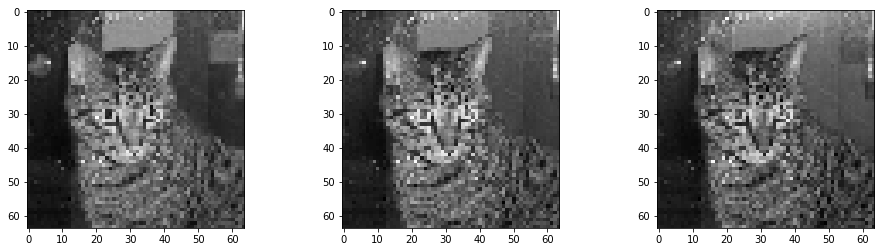

In [23]:
import cv2

f,ax = plt.subplots(1,3, figsize=(16,4))
for i in range(3):
    img = test_image[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i].imshow(img, cmap='gray')
    cv2.imwrite('layer0-'+str(i)+'.png', img)


(1, 62, 62, 8)


IndexError: index 8 is out of bounds for axis 3 with size 8

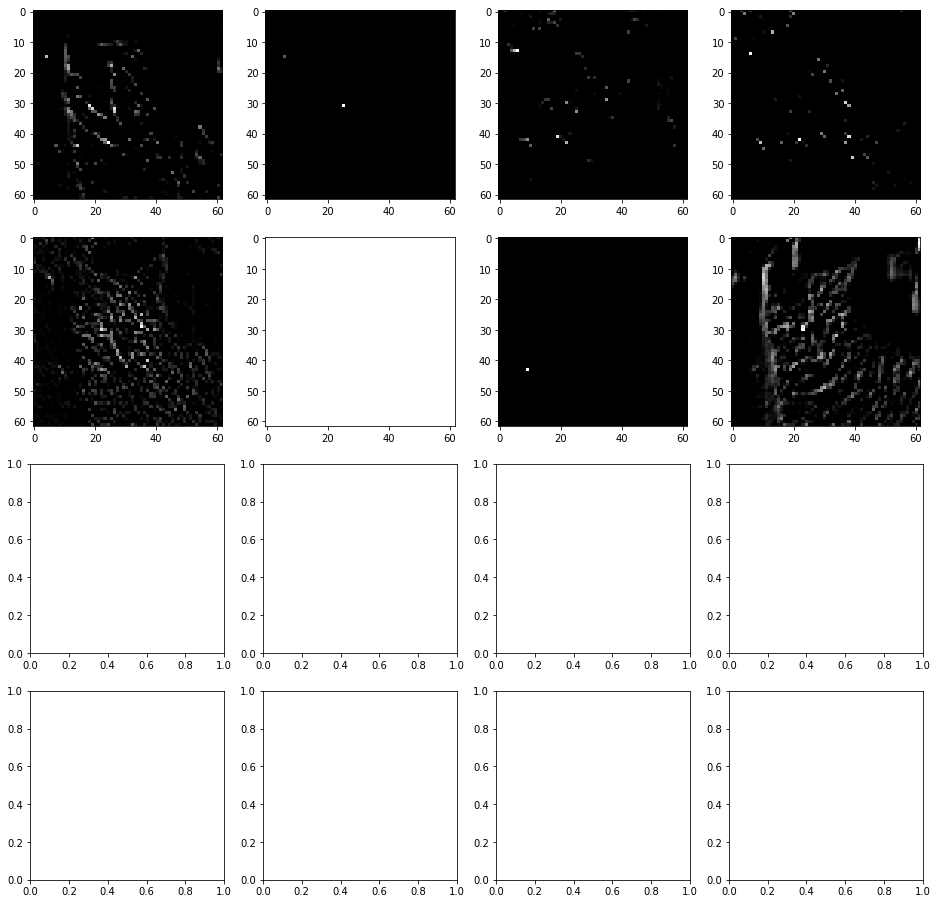

In [24]:
from keras.engine.topology import Input

first = Sequential()
first.add(model.layers[0])
first.compile(optimizer='adam', loss = 'binary_crossentropy')

out = first.predict(test_image)
print(out.shape)
f,ax = plt.subplots(4,4, figsize=(16,16))
for i in range(16):
    img = out[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i//4,i%4].imshow(img, cmap='gray')
    cv2.imwrite('layer1-'+str(i)+'.png', img)


Note that some of these images are completely white they carry no information. They are in fact dropped from the network due to the `Dropout` layer which appears later. We can investigate the numerical values of all 16 images by

In [ ]:
for i in range(16):
    print(np.min(out[0,:,:,i]), np.max(out[0,:,:,i]))


## Looking at the second layer

In [ ]:
from keras.engine.topology import Input

# print(model.layers[0])
# print(model.layers[1])
# print(model.layers[2])

second = Sequential()
second.add(model.layers[0]) # add 1st conv layer, produces 16 images
second.add(model.layers[1]) # maxpooling: reduce the size all images
second.add(model.layers[2]) # 2nd convolution layer, produces 32 images
second.compile(optimizer='adam', loss = 'binary_crossentropy')

out = second.predict(test_image)

# print(out.shape)
# for i in range(32):
#     print(np.min(out[0,:,:,i]), np.max(out[0,:,:,i]))

f,ax = plt.subplots(8,4, figsize=(16,32))
for i in range(32):
    img = out[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i//4,i%4].imshow(img, cmap='gray')
    ax[i//4,i%4].axis('off')
    cv2.imwrite('layer2-'+str(i)+'.png', img)



In [ ]:
third = Sequential()
for i in range(6):
    third.add(model.layers[i])
third.compile(optimizer='adam', loss = 'binary_crossentropy')

out = third.predict(test_image)

# print(out.shape)
# for i in range(64):
#     print(np.min(out[0,:,:,i]), np.max(out[0,:,:,i]))

f,ax = plt.subplots(16,4, figsize=(16,32))
for i in range(64):
    img = out[0,:,:,i]
    img = np.log(img+.1)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i//4,i%4].imshow(img, cmap='gray')
    ax[i//4,i%4].axis('off')
    cv2.imwrite('layer3-'+str(i)+'.png', img)



## Comparing what the layers see: cat vs dog

We will now look at one cat and one dog image to see what the different layers pay attention to

In [ ]:
cat = image.load_img('../cats_dogs/single_prediction/cat.1.jpg', target_size = (256, 256))
cat = image.img_to_array(cat)
cat = np.expand_dims(cat, axis = 0)
dog = image.load_img('../cats_dogs/single_prediction/dog.10.jpg', target_size = (256, 256))
dog = image.img_to_array(dog)
dog = np.expand_dims(dog, axis = 0)

out_cat = first.predict(cat)
out_dog = first.predict(dog)

f,ax = plt.subplots(8,2, figsize=(16,32))
for i in range(8):
    img = out_cat[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i,0].imshow(img)
    
    img = out_dog[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i,1].imshow(img)


In [ ]:
out_cat = second.predict(cat)
out_dog = second.predict(dog)

f,ax = plt.subplots(8,2, figsize=(16,32))
for i in range(8):
    img = out_cat[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i,0].imshow(img)
    
    img = out_dog[0,:,:,i]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    ax[i,1].imshow(img)


## Looking at the fully connected layers

Looking at fully connected layers is always a bit tricky as their intrepretation is highly convoluted. In very rare cases you can make sense of indiviual neurons. They are best thought of as high-level features such as "ears", "fur", "eyes", etc which are a combination of many many edges, shapes and averages (which convolution operations produce), but they seldom are as identifiable as the ones listed above. They are high-level features which the computer algorithm finds interesting, but they might not be identifiable by us.

However, what we can do is try and look at what the cat and dog image will produce and see if there is any significant difference.

In [ ]:
for one_layer in model.layers:
    print(one_layer)

dense = Sequential()
for i in range(10):
    dense.add(model.layers[i]) # all layers up to the last dropout & dense 
dense.compile(optimizer='adam', loss = 'binary_crossentropy')

cat_out = dense.predict(cat)
dog_out = dense.predict(dog)

print(cat_out.shape)
f = plt.figure(figsize=(16,3))
plt.plot(cat_out.T)
plt.plot(dog_out.T)
plt.legend(['cat', 'dog'])
plt.show()